In [21]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

main_folder = '/Users/evangelosgeraridis/Desktop/b20'

for subfolder in os.listdir(main_folder):
    if subfolder == '.DS_Store':
        continue

    subfolder_path = os.path.join(main_folder, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    # Load the fridge data
    fridge_file = os.path.join(subfolder_path, '01_fridge.parquet.gzip')
    fridge_data = pd.read_parquet(fridge_file)

    # Load the rice cooker data
    rice_cooker_file = os.path.join(subfolder_path, '02_rice-cooker.parquet.gzip')
    rice_cooker_data = pd.read_parquet(rice_cooker_file)

    # Load the total data
    total_file = os.path.join(subfolder_path, '00_total.parquet.gzip')
    total_data = pd.read_parquet(total_file)

    

In [22]:
combined_data = pd.concat([total_data, fridge_data, rice_cooker_data], axis=1)
data = pd.DataFrame()
data = data.append(combined_data)
data

/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/954569428.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(combined_data)


,active_power,reactive_power,timestamp,active_power,reactive_power,timestamp,active_power,reactive_power,timestamp
1288530,329.81,-265.54,1.488845e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288531,334.01,-265.55,1.488845e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288532,330.44,-265.68,1.488845e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288533,334.51,-264.98,1.488845e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288534,328.51,-265.15,1.488845e+12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1288525,627.87,-25.73,1.488931e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288526,576.82,-25.09,1.488931e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288527,550.50,-26.27,1.488931e+12,NaN,NaN,NaN,NaN,NaN,NaN
1288528,542.86,-24.74,1.488931e+12,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data = data.dropna()
data.columns = ['total_active_power','total_reactive_power','ts', 'fridge_active_power', 'fridge_reactive_power', 'ts1','rice_active_power', 'rice_reactive_power','ts2']
data = data.drop(['ts1','ts2'],axis=1)
data = data.set_index('ts')
data

,total_active_power,total_reactive_power,fridge_active_power,fridge_reactive_power,rice_active_power,rice_reactive_power
ts,,,,,,
1.488845e+12,297.21,-33.64,60.46,14.41,0.27,1.86
1.488845e+12,295.79,-32.67,60.19,14.29,0.24,1.82
1.488845e+12,310.30,-33.19,65.13,14.14,0.27,1.86
1.488845e+12,300.99,-33.90,68.72,14.56,0.32,1.88
1.488845e+12,335.86,-32.40,68.40,14.39,0.30,1.87
...,...,...,...,...,...,...
1.488930e+12,286.65,-48.08,0.00,0.00,0.29,1.96
1.488930e+12,328.17,-44.67,0.00,0.00,0.24,1.75
1.488930e+12,329.20,-44.09,0.00,0.00,0.18,1.87


In [42]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

# Example usage
X = data[['total_active_power', 'total_reactive_power']].values
Y = data[['fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=4)
hart85_disaggregator.train(X_train)

disaggregated_data = hart85_disaggregator.disaggregate(X_test)

rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 28.68640530186755
MAE: 11.358634147099458
RMAE: 2.5265782606183
MSE: 822.9098491430146


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 40.470687101057464
MAE: 21.619292984478854
RMAE: 1.8721678075754637
MSE: 1637.8765144316988


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/1315874692.py:112: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


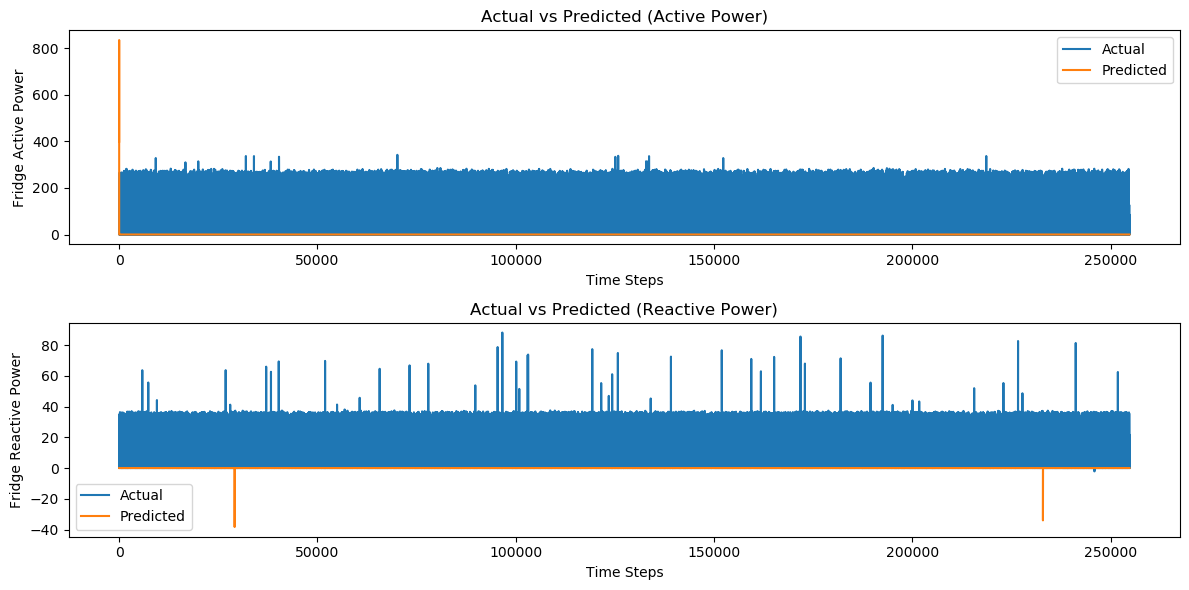

In [12]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

# Example usage
# Example usage
X = data[['total_active_power', 'total_reactive_power']].values
Y = data[['fridge_active_power', 'fridge_reactive_power']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2)
hart85_disaggregator.train(X_train)

disaggregated_data = hart85_disaggregator.disaggregate(X_test)

rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")

# Plotting
time_steps = np.arange(Y_test.shape[0])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_steps, Y_test[:, 0], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 0], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Fridge Active Power')
plt.title('Actual vs Predicted (Active Power)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_steps, Y_test[:, 1], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Fridge Reactive Power')
plt.title('Actual vs Predicted (Reactive Power)')
plt.legend()

plt.tight_layout()
plt.show()


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 1.874674130624514
MAE: 1.0932830477797135
RMAE: 1.7187923298824572
MSE: 3.514403096032778


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/2829669322.py:113: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


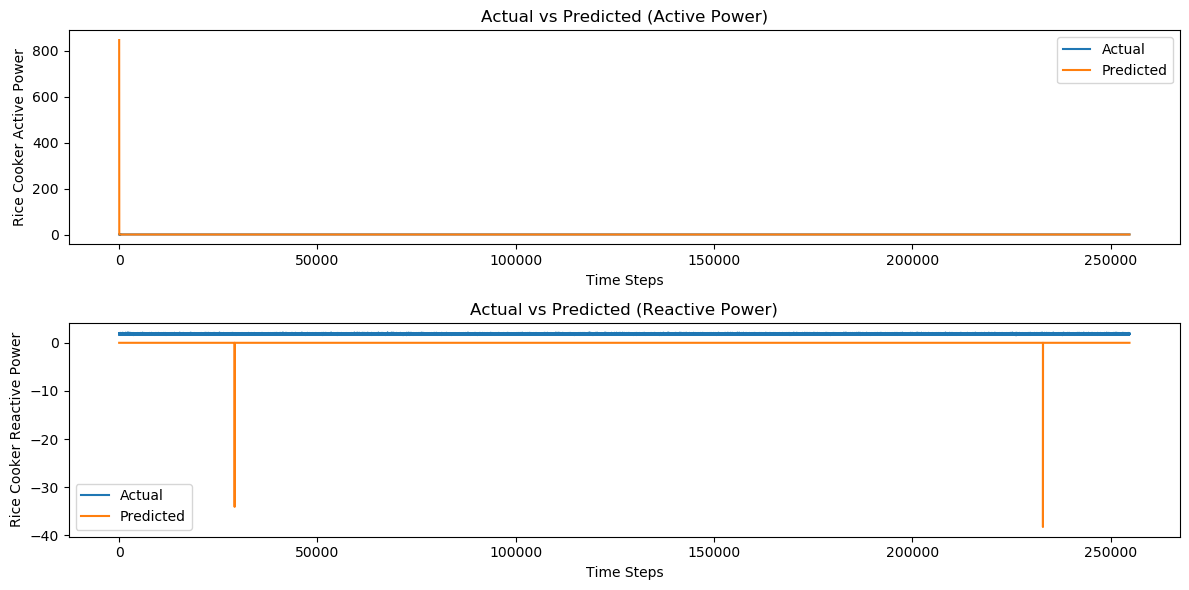

In [11]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

# Example usage
# Example usage
# Example usage
X = data[['total_active_power', 'total_reactive_power']].values
Y = data[['rice_active_power', 'rice_reactive_power']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2)
hart85_disaggregator.train(X_train)

disaggregated_data = hart85_disaggregator.disaggregate(X_test)

rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")

# Plotting
time_steps = np.arange(Y_test.shape[0])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_steps, Y_test[:, 0], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 0], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Rice Cooker Active Power')
plt.title('Actual vs Predicted (Active Power)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_steps, Y_test[:, 1], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Rice Cooker Reactive Power')
plt.title('Actual vs Predicted (Reactive Power)')
plt.legend()

plt.tight_layout()
plt.show()


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 40.4676748872248
MAE: 21.618953587787463
RMAE: 2.5986461048046396
MSE: 1637.6327107781249


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/1150554581.py:119: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


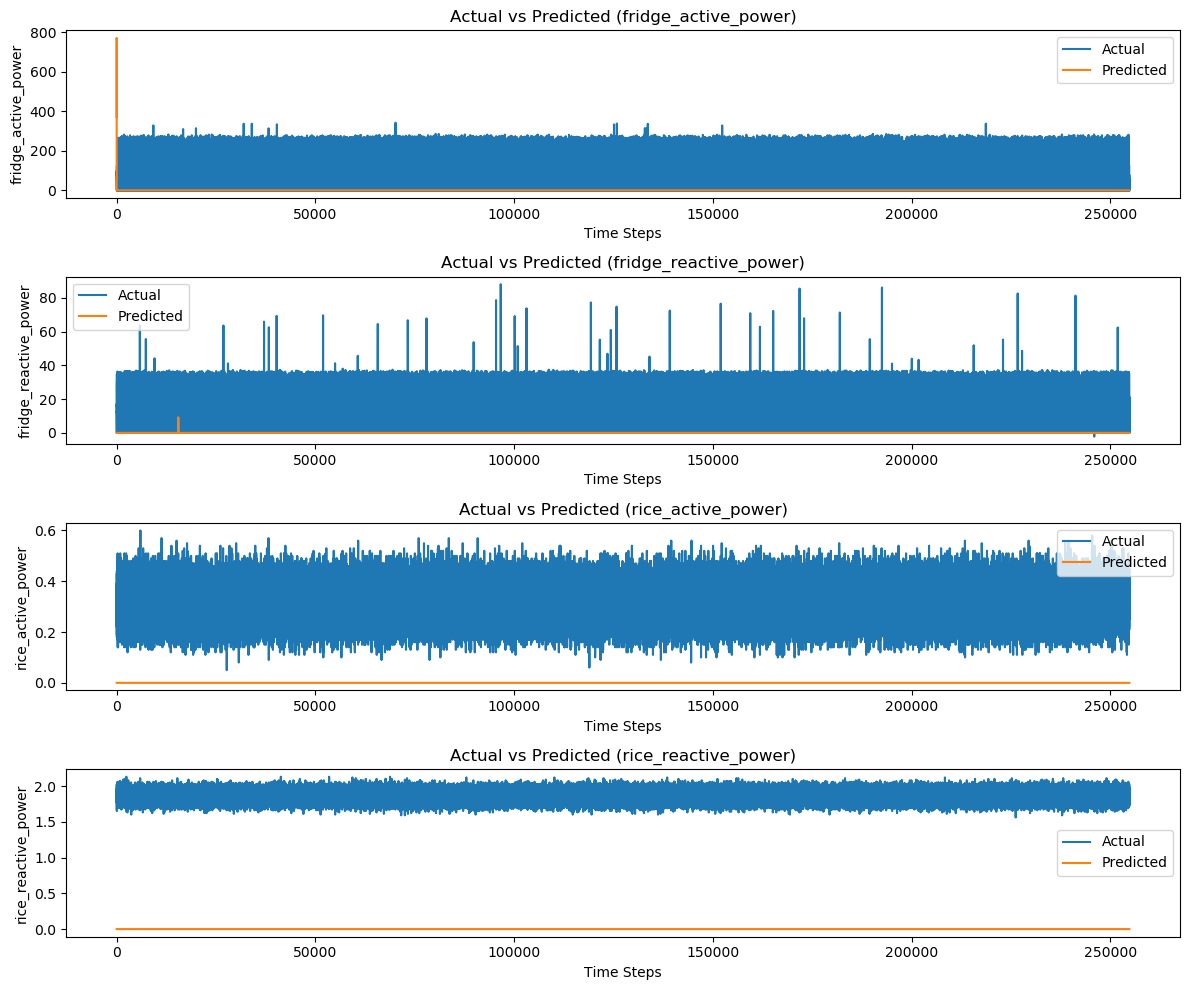

In [17]:
#INTRUSIVE HART85 (USING ALL 6 COLUMNS TO PREDICT THE 4 THAT ARE REFFERENCED TO THE 2 APPLIANCES METRICS)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        num_features = X_true.shape[1] // 2
        X_true_relevant = X_true[:, :num_features]
        X_pred_relevant = X_pred[:, :num_features]
        return np.sqrt(mean_squared_error(X_true_relevant, X_pred_relevant))

    def calculate_mae(self, X_true, X_pred):
        num_features = X_true.shape[1] // 2
        X_true_relevant = X_true[:, :num_features]
        X_pred_relevant = X_pred[:, :num_features]
        return mean_absolute_error(X_true_relevant, X_pred_relevant)

    def calculate_rmae(self, X_true, X_pred):
        num_features = X_true.shape[1] // 2
        X_true_relevant = X_true[:, :num_features]
        X_pred_relevant = X_pred[:, :num_features]
        rmse = self.calculate_rmse(X_true_relevant, X_pred_relevant)
        return rmse / np.mean(X_true_relevant)

    def calculate_mse(self, X_true, X_pred):
        num_features = X_true.shape[1] // 2
        X_true_relevant = X_true[:, :num_features]
        X_pred_relevant = X_pred[:, :num_features]
        return mean_squared_error(X_true_relevant, X_pred_relevant)

# Example usage
X = data[['total_active_power', 'total_reactive_power', 'fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values
Y = data[['fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2)
hart85_disaggregator.train(X_train)

disaggregated_data = hart85_disaggregator.disaggregate(X_test)

rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")

# Plotting
time_steps = np.arange(Y_test.shape[0])

column_names = ['fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']

plt.figure(figsize=(12, 10))

for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time_steps, Y_test[:, i], label='Actual')
    plt.plot(time_steps, disaggregated_data[:, i], label='Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel(column_names[i])
    plt.title(f'Actual vs Predicted ({column_names[i]})')
    plt.legend()

plt.tight_layout()
plt.show()

/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 223.96927328044129
MAE: 96.01431170381962
RMAE: 2.682133944112033
MSE: 50162.23537376899


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/2085881196.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


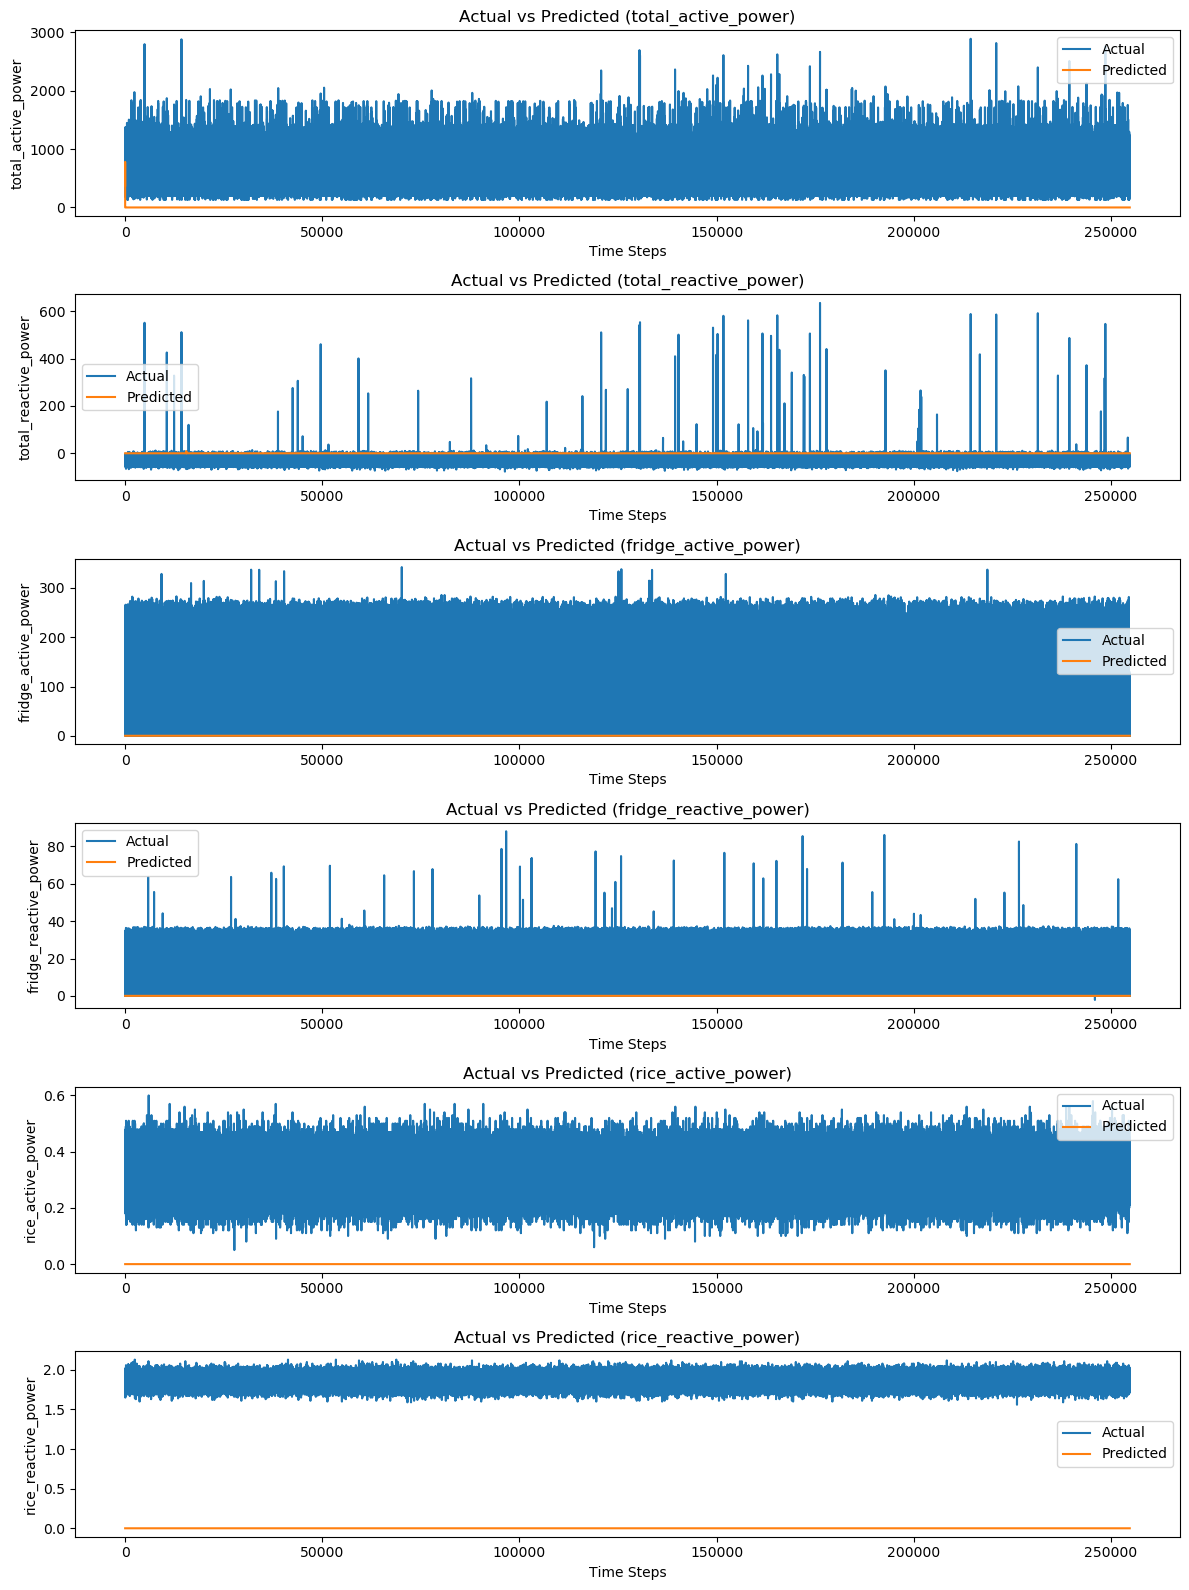

In [18]:
#INTRUSIVE USING 6 COLS TO PREDICT 6
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

# Example usage
X = data[['total_active_power', 'total_reactive_power', 'fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values
Y = data[['total_active_power', 'total_reactive_power', 'fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2)
hart85_disaggregator.train(X_train)

disaggregated_data = hart85_disaggregator.disaggregate(X_test)

rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")

# Plotting
time_steps = np.arange(Y_test.shape[0])
column_names = ['total_active_power', 'total_reactive_power', 'fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']

plt.figure(figsize=(12, 16))

for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(time_steps, Y_test[:, i], label='Actual')
    plt.plot(time_steps, disaggregated_data[:, i], label='Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel(column_names[i])
    plt.title(f'Actual vs Predicted ({column_names[i]})')
    plt.legend()

plt.tight_layout()
plt.show()


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 40.46768210305924
MAE: 21.61895405092841
RMAE: 1.8720287968267693
MSE: 1637.6332947942612


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/1207438846.py:115: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


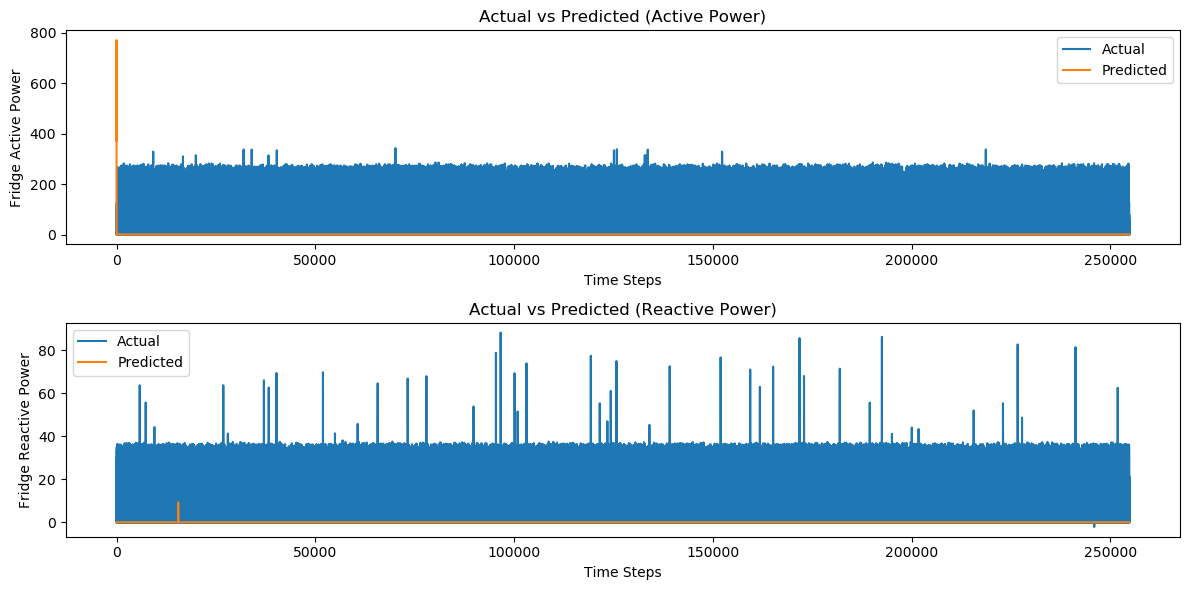

In [26]:
#all 6 predict the 2 fridges cols (active,reactive)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y[:, :2]

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

# Prepare the data
data = data
X = data[['total_active_power', 'total_reactive_power', 'fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values
Y = data[[ 'fridge_active_power', 'fridge_reactive_power']].values

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train and disaggregate using Hart85 model
hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2)
hart85_disaggregator.train(X_train)
disaggregated_data = hart85_disaggregator.disaggregate(X_test)

# Calculate metrics
rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")

# Plotting
time_steps = np.arange(Y_test.shape[0])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_steps, Y_test[:, 0], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 0], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Fridge Active Power')
plt.title('Actual vs Predicted (Active Power)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_steps, Y_test[:, 1], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Fridge Reactive Power')
plt.title('Actual vs Predicted (Reactive Power)')
plt.legend()

plt.tight_layout()
plt.show()


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 1.7993855406268489
MAE: 1.09295908630011
RMAE: 1.6497640924401753
MSE: 3.237788323816977


/var/folders/nc/r0ghbp811_gdhf1gdndmcjt40000gn/T/ipykernel_935/3017070762.py:117: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


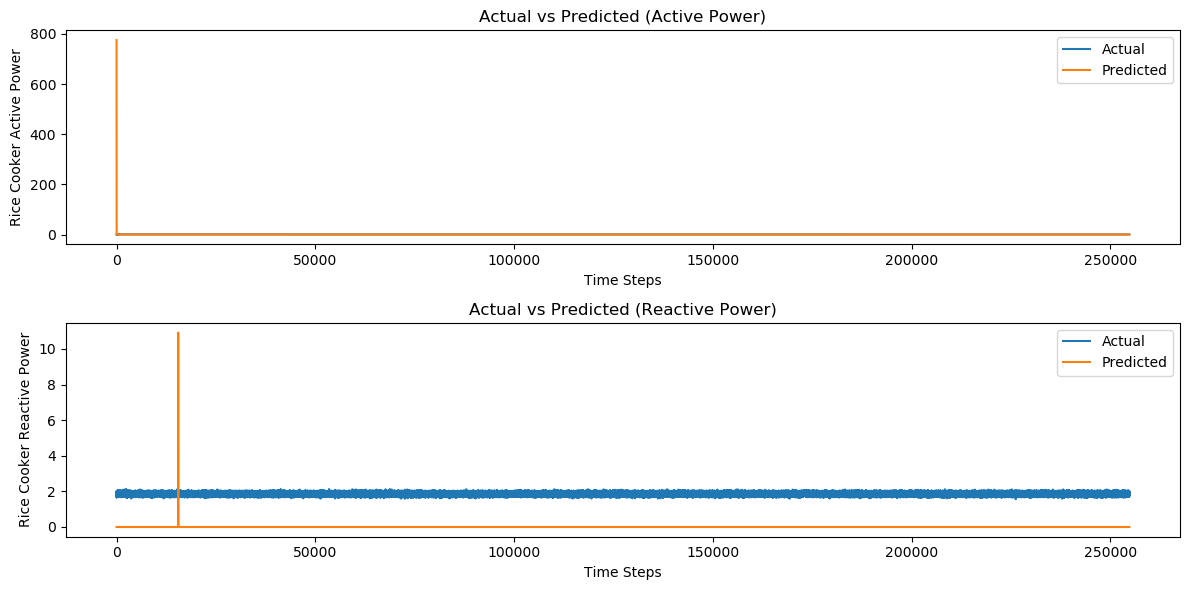

In [28]:
#all 6 predict the 2 rice cookers cols (active,reactive)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

class Hart85:
    def __init__(self, num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y[:, :2]

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)

# Prepare the data
data = data
X = data[['total_active_power', 'total_reactive_power', 'fridge_active_power', 'fridge_reactive_power', 'rice_active_power', 'rice_reactive_power']].values
Y = data[[ 'rice_active_power', 'rice_reactive_power']].values

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train and disaggregate using Hart85 model
hart85_disaggregator = Hart85(num_states=2, num_cluster_init=10, num_cycles_init=2, num_cluster=2)
hart85_disaggregator.train(X_train)
disaggregated_data = hart85_disaggregator.disaggregate(X_test)

# Calculate metrics
rmse = hart85_disaggregator.calculate_rmse(Y_test, disaggregated_data)
mae = hart85_disaggregator.calculate_mae(Y_test, disaggregated_data)
rmae = hart85_disaggregator.calculate_rmae(Y_test, disaggregated_data)
mse = hart85_disaggregator.calculate_mse(Y_test, disaggregated_data)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"MSE: {mse}")

# Plotting
time_steps = np.arange(Y_test.shape[0])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_steps, Y_test[:, 0], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 0], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Rice Cooker Active Power')
plt.title('Actual vs Predicted (Active Power)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_steps, Y_test[:, 1], label='Actual')
plt.plot(time_steps, disaggregated_data[:, 1], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Rice Cooker Reactive Power')
plt.title('Actual vs Predicted (Reactive Power)')
plt.legend()

plt.tight_layout()
plt.show()
